In [1]:
try:
    # importing the libraries
    from numba import jit, cuda 
    import pandas as pd
    import numpy as np
    import cv2
    import timeit

    import glob
    import os

    # for reading and displaying images
    from skimage.io import imread
    import matplotlib.pyplot as plt
    %matplotlib inline

    # for creating validation set
    from sklearn.model_selection import train_test_split
    from skimage.color import rgb2gray, gray2rgb

    # for evaluating the model
    from sklearn.metrics import accuracy_score
    from tqdm import tqdm

    # PyTorch libraries and modules
    import torch
    from torch.autograd import Variable
    from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
    from torch.optim import Adam, SGD

    import torchvision
except Exception as error:
    !pip install {str(error)[17:-1]}
except:
    !pip install scikit-image
    print("Pacote não encontrado")

In [2]:
lesions = {0: "Basal Cell Carcinoma", 
    1: "Lentigo",
    2: "Malignant Melanoma", 
    3: "Melanocytic naevus",
    4: "seborrhoeic keratosis",
    5: "Wart", 
    6: "Actinic Keratosis",
    7: "Squamous Cell Carcinoma",
    8: "Intraepithelial Carcinoma", 
    9: "Pyogenic Granuloma",
    10: "Haemangioma",
    11: "Dermatofibroma"
}

In [3]:
train = pd.read_csv('train.csv',index_col=0)
test = pd.read_csv('test.csv',index_col=0)
val = pd.read_csv('val.csv',index_col=0)

train_y = train['label'].values
test_y = test['label'].values
val_y = val['label'].values

train.head()

,id,label
0,37,5
1,14,5
2,28,5
3,16,5
4,29,5


In [4]:

df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)
df_val = pd.DataFrame(val)

def img_array(dataframe, img_type):
    train_img = []
    for index, row in tqdm(dataframe.iterrows()):
        # defining the image path
        try:
            if int(row['id']) or row['id'] == str(0):
                image_path = 'dataset-split/' + img_type + '/' + lesions[row['label']] + "/" + str(row['id']) + '.png'
        except:
            image_path = 'dataset-split/' + img_type + '/' + lesions[row['label']] + "/resnet_augmented/" + str(row['id']) + '.png'
        # reading the image
        img = cv2.imread(image_path)

        # normalize
        img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        # appending the image into the list
        train_img.append(img)

    return train_img

In [5]:
# converting the list to numpy array
train = img_array(df_train, 'train')
train_x = np.array(train)
train_x.shape, train_y.shape

53820it [00:44, 1215.74it/s]


((53820, 128, 128, 3), (53820,))

In [6]:
# converting the list to numpy array
val = img_array(df_val, 'val')
val_x = np.array(val)
val_x.shape, val_y.shape

6570it [00:06, 1052.79it/s]


((6570, 128, 128, 3), (6570,))

In [7]:
# converting the list to numpy array
test = img_array(df_test, 'test')
test_x = np.array(test)
test_x.shape, test_y.shape

7050it [00:06, 1075.50it/s]


((7050, 128, 128, 3), (7050,))

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7fe6974d9b80>)

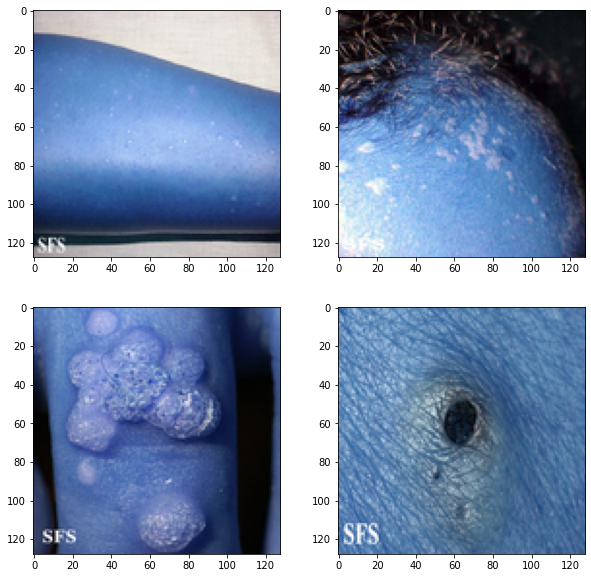

In [8]:
i = 0
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_x[i])
plt.subplot(222), plt.imshow(train_x[i+25])
plt.subplot(223), plt.imshow(train_x[i+50])
plt.subplot(224), plt.imshow(train_x[i+75])

In [9]:
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((53820, 128, 128, 3), (53820,)), ((6570, 128, 128, 3), (6570,)))

In [10]:
train_x = train_x.reshape(53820, 3, 128, 128)
train_x = torch.from_numpy(train_x)

train_y = train_y.astype(int)
train_y = torch.from_numpy(train_y)

train_x.shape, train_y.shape

(torch.Size([53820, 3, 128, 128]), torch.Size([53820]))

In [11]:
val_x = val_x.reshape(6570, 3, 128, 128)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(int)
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([6570, 3, 128, 128]), torch.Size([6570]))

In [25]:
model = torchvision.models.resnet152()

optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [32]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    print(x_train.cuda())
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()


    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [33]:
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []

# training the model
for epoch in range(n_epochs):
    train(epoch)

RuntimeError: CUDA out of memory. Tried to allocate 9.86 GiB (GPU 0; 7.93 GiB total capacity; 1.65 GiB already allocated; 4.46 GiB free; 1.68 GiB reserved in total by PyTorch)